# Data Science project

This project explores the MineCraft server and player data collected from Frank Woods reseach group in Computer Science at UBC. 

https://plai.cs.ubc.ca/
https://www.cs.ubc.ca/~fwood/



# Predictive question: Is there a relationship between hours played and age that predicts wheather a player has a newsletter subscription?

In the `player.csv` data set, 

- experience: a rank ascending from begeinner, amature, regular, pro and veteran
- subscribe: whether the individual is subscribed or not to the newsletter
- hashedEmail: individuals encrypted email address
- played_hours: how many hours an individual player within XXXXX
- name: individuals first name
- gender: individuals gender
- Age: individuals gender



In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

# Data Exploration and Visualization

In [2]:
set.seed(1)
player_data <- read_csv("data/players.csv") |>
    mutate(subscribe = as_factor(subscribe))
player_data

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


In [3]:
select_player_data <- player_data |> 
    select(subscribe, Age, played_hours)
select_player_data

summary(select_player_data)

subscribe,Age,played_hours
<fct>,<dbl>,<dbl>
TRUE,9,30.3
TRUE,17,3.8
FALSE,17,0.0
⋮,⋮,⋮
FALSE,17,0.0
FALSE,17,2.3
TRUE,NA,0.2


 subscribe        Age         played_hours    
 FALSE: 52   Min.   : 8.00   Min.   :  0.000  
 TRUE :144   1st Qu.:17.00   1st Qu.:  0.000  
             Median :19.00   Median :  0.100  
             Mean   :20.52   Mean   :  5.846  
             3rd Qu.:22.00   3rd Qu.:  0.600  
             Max.   :50.00   Max.   :223.100  
             NA's   :2                        

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


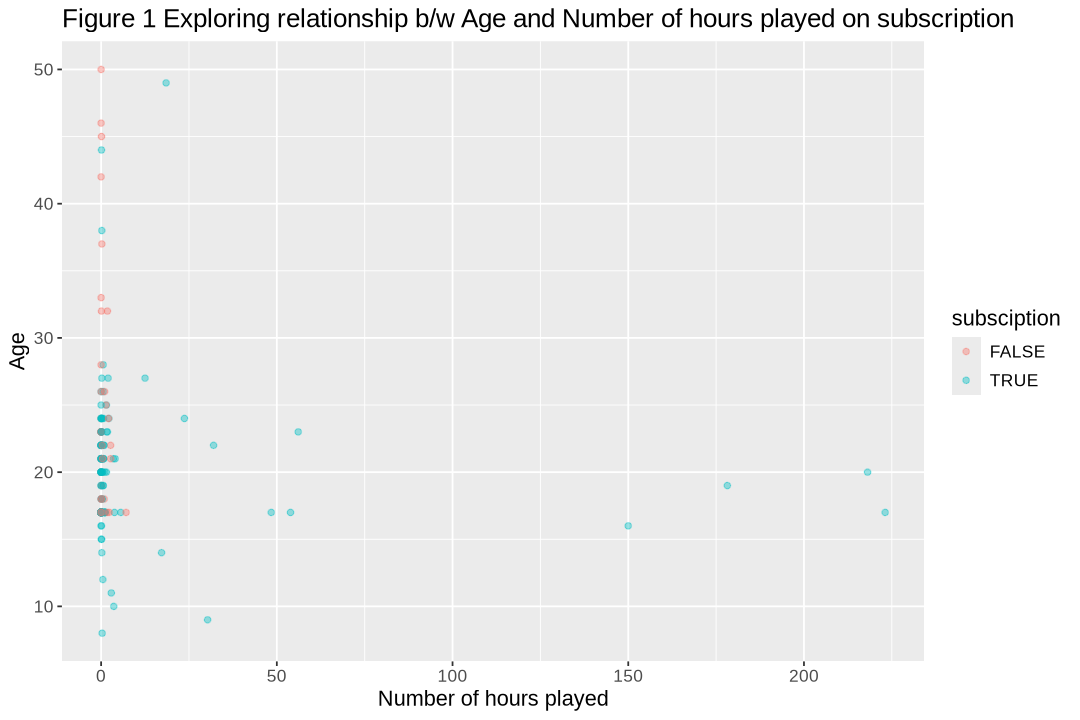

In [4]:
options(repr.plot.height = 6, repr.plot.width = 9)

player_data_plot <- select_player_data |>
    ggplot(aes(x = played_hours, y = Age, color = subscribe)) +
    geom_point(alpha = 0.4) +
    labs(x = "Number of hours played", 
         y = "Age", 
         title = "Figure 1 Exploring relationship b/w Age and Number of hours played on subscription",
        color = "subsciption") +  
    theme(text = element_text(size = 13))
player_data_plot 

From Figure 1. we can clearly see that all individuals with a high number of 25+ hours played have newsletter subscription. However, individuals with 0 hours vary in subscriptions 

# Data Analysis
To determine if there's a relationship between hours played and age that predicts whether a player has a subscription, I approached this question as a classification problem.

`subscribe` has 2 categories `TRUE`(subscribed) or `FALSE`(unsubscribed) and as the outcome variable we turned it into a factor in the previous lines of code.

Split data and evaluate proportions 

In [5]:
player_split <- initial_split(player_data, prop = 0.75, strata = subscribe)
player_train <- training(player_split)
player_test <- testing(player_split)

player_train <- player_train |>
    drop_na()
player_test <- player_test |>
    drop_na()

player_train_proportions <- player_train |>
                      group_by(subscribe) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(player_train))

player_train_proportions

subscribe,n,percent
<fct>,<int>,<dbl>
FALSE,39,26.89655
TRUE,106,73.10345


Looking at the proportions in the training data, we need to keep in mind that there isnt an equal amount of people subscribed and unsubscribed so we want to make sure we calculate recall (to catch as many sctual subscibers) and precision (to be correct most of the time)

Preprocess data and train the classifier 

to standardize with the training data, make a model with k = 3 (just a guess by looking at Figure 1) and combine them with workflow then fit to build classifier

In [6]:
player_recipe <- recipe(subscribe ~ Age + played_hours, data = player_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
  set_engine("kknn") |>
  set_mode("classification")


knn_fit <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(knn_spec) |>
  fit(data = player_train)

knn_fit


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(3,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3793103
Best kernel: rectangular
Best k: 3

predicting labels in the test set and evaluating our classifier's performance

In [7]:
set.seed(1)
player_test_predictions <- predict(knn_fit, player_test) |>
  bind_cols(player_test)

player_test_predictions

player_test_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")



player_test_predictions |> pull(subscribe) |> levels()

player_test_predictions |>
  precision(truth = subscribe, estimate = .pred_class, event_level = "first")

player_test_predictions |>
  recall(truth = subscribe, estimate = .pred_class, event_level = "first")


.pred_class,experience,subscribe,hashedEmail,played_hours,name,gender,Age
<fct>,<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>
TRUE,Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
TRUE,Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
FALSE,Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
FALSE,Amateur,TRUE,b6e9e593b9ec51c5e335457341c324c34a2239531e1890b93ca52ac1dc76b08f,0.0,Bailey,Female,17
FALSE,Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
TRUE,Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5102041


[1] "FALSE" "TRUE"

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.2105263


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.3076923


Evaluating the performance with a random k values of 3, 51% accuracy, 21% precision and 30% recall is not very good.

We are going to try and improve these percentages by with tuning the classifier with cross validation (multiple splits)

Cross - validation

In [12]:
# player_split <- initial_split(player_train, prop = 0.75, strata = subscribe)
# player_subtrain <- training(player_split)
# player_validation <- testing(player_split)

player_vfold <- vfold_cv(player_train, v = 5, strata = subscribe)

player_recipe <- recipe(subscribe ~ Age + played_hours,
                        data = player_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

knn_results <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = player_vfold, grid = k_vals) |>
  collect_metrics()

accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracies


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5103284,5,0.02475633,Preprocessor1_Model01
2,accuracy,binary,0.5103284,5,0.02475633,Preprocessor1_Model02
3,accuracy,binary,0.5938424,5,0.03023242,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
8,accuracy,binary,0.6692939,5,0.01582330,Preprocessor1_Model08
9,accuracy,binary,0.6688342,5,0.02350363,Preprocessor1_Model09
10,accuracy,binary,0.6616913,5,0.02100272,Preprocessor1_Model10


[1] 7

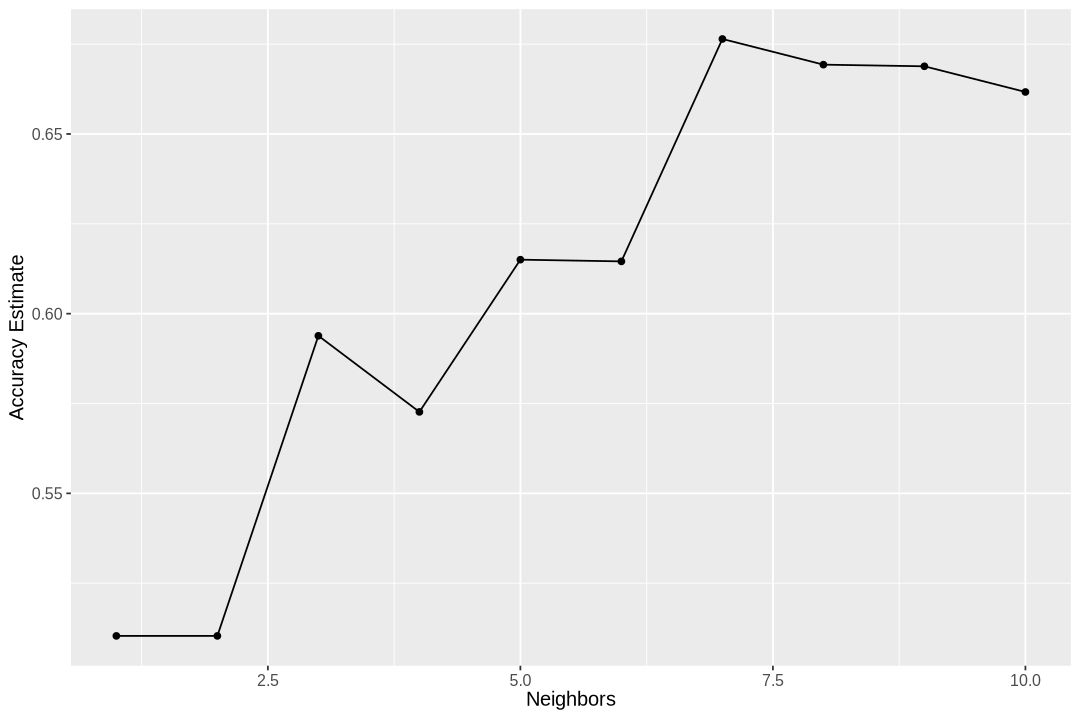

In [15]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

accuracy_vs_k

best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

in this case the best number of neighbors from a  was k = 7 with a round 67% accuracy